In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }
gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros

def get_source(dx, dy, dI):
    settings = toliman_settings.copy()
    settings['tilt_x'] = dx
    settings['tilt_y'] =dy
    new  = {
            'wavelengths': [wavelength],
            'weights': [dI],
            'settings': settings
            }
    return new

In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
# First source, on axis
# Second source, offset 5" and fainter
from proper_tools import form_detector_image
from time import time
ts = time()
raw_image = form_detector_image('prescription_rc_quad', [get_source(0,0,1.), get_source(0,5.,1./3.)], gridsize, detector_pitch, npixels)#,multi=False)
te = time()
print('Generated detector image in {}s'.format(te-ts))

/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Generated detector image in 18.578853845596313s


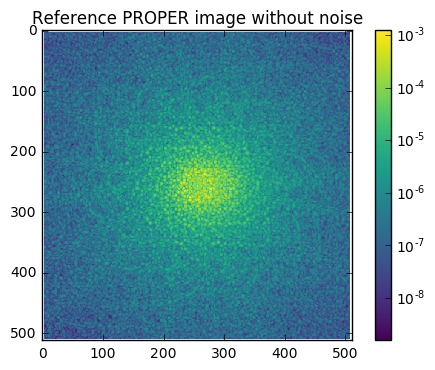

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

25217743.5446


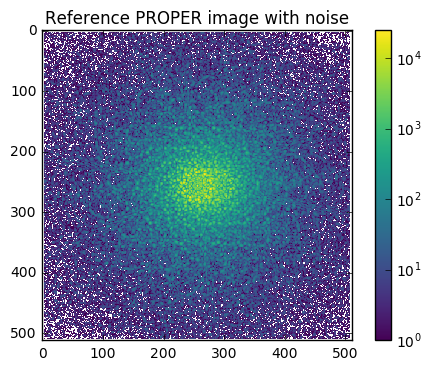

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

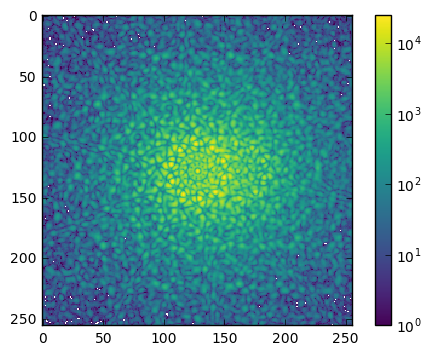

In [8]:
plt.imshow(detector_image[128:128*3,128:128*3], interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.show()

# Fit by tweaking position and flux


In [9]:
# Function to generate 
errors = []
def model_err(params, view=False):
    t=time()
    tiltx1 = params[0]
    tilty1 = params[1]
    flux1 = params[2]
    tiltx2 = params[3]
    tilty2 = params[4]
    flux2 = params[5]    
    im = form_detector_image('prescription_rc_quad', [get_source(tiltx1,tiltx1,flux1), get_source(tiltx2,tiltx2,flux2)], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale#*flux
    error = np.sum((im - detector_image)**2)
    t=time()-t
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        plt.show()
    errors.append((params,error,t))
    print('Error for offsets ({:.2e},{:.2e}),({:.2e},{:.2e}) and fluxes {:.2e},{:.2e}: {}% baseline in {}s '.format(tiltx1, tiltx1, tiltx2, tiltx2, flux1, flux2, round(100.*error/min_err),t))
    return error

## Optimize

In [13]:
from skopt import gp_minimize
errors=[]
params_init = [(-10,10),(-10,10),(1.0, 2.0),(-10,10),(-10,10),(0.1,1.0)]
res = gp_minimize(model_err, params_init)

Error for offsets (5.00e+00,5.00e+00),(8.00e+00,8.00e+00) and fluxes 1.48e+00,9.27e-01: 1123727.0% baseline in 18.958627462387085s 
Error for offsets (4.00e+00,4.00e+00),(-6.00e+00,-6.00e+00) and fluxes 1.91e+00,2.72e-01: 999145.0% baseline in 18.856765747070312s 
Error for offsets (9.00e+00,9.00e+00),(-3.00e+00,-3.00e+00) and fluxes 1.03e+00,1.45e-01: 580568.0% baseline in 18.95720601081848s 
Error for offsets (1.00e+01,1.00e+01),(2.00e+00,2.00e+00) and fluxes 1.09e+00,2.05e-01: 607926.0% baseline in 18.95722222328186s 
Error for offsets (8.00e+00,8.00e+00),(-3.00e+00,-3.00e+00) and fluxes 1.92e+00,4.69e-01: 1240334.0% baseline in 18.853288888931274s 
Error for offsets (7.00e+00,7.00e+00),(1.00e+01,1.00e+01) and fluxes 1.59e+00,6.97e-01: 1210913.0% baseline in 18.853359937667847s 
Error for offsets (3.00e+00,3.00e+00),(7.00e+00,7.00e+00) and fluxes 1.11e+00,2.08e-01: 465960.0% baseline in 18.855627059936523s 
Error for offsets (0.00e+00,0.00e+00),(4.00e+00,4.00e+00) and fluxes 1.30e+0

In [14]:
print(res)

          fun: 19018899309.145405
    func_vals: array([  2.83378523e+11,   2.51961772e+11,   1.46406070e+11,
         1.53305312e+11,   3.12784185e+11,   3.05364844e+11,
         1.17504636e+11,   4.25722441e+10,   2.00014342e+11,
         2.98401161e+11,   2.63530528e+11,   4.40687114e+10,
         2.45387344e+11,   1.92133182e+11,   4.02153287e+10,
         4.16475676e+10,   3.73279187e+10,   3.30266431e+10,
         4.39546827e+10,   3.53412914e+10,   3.57670417e+10,
         3.19792972e+10,   3.61190086e+10,   3.38442616e+10,
         3.14192333e+10,   3.51848862e+10,   3.41331424e+10,
         2.68397611e+10,   2.94610910e+10,   4.49452233e+10,
         3.87458027e+10,   3.61032156e+10,   4.42732730e+10,
         2.79176281e+10,   3.25500471e+10,   3.27637357e+10,
         4.74614880e+10,   3.06762177e+10,   3.51566796e+10,
         2.41103425e+10,   3.51957235e+10,   2.94318314e+10,
         3.80343298e+10,   2.63879658e+10,   3.95683302e+10,
         2.93809102e+10,   3.6362643

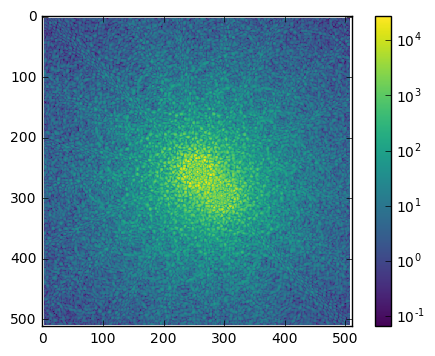

Error for offsets (0.00e+00,0.00e+00),(6.00e+00,6.00e+00) and fluxes 1.08e+00,4.84e-01: 75419.0% baseline in 18.659152507781982s 


19018899309.145405

In [15]:
# How do things look now?
model_err(res.x, view=True)

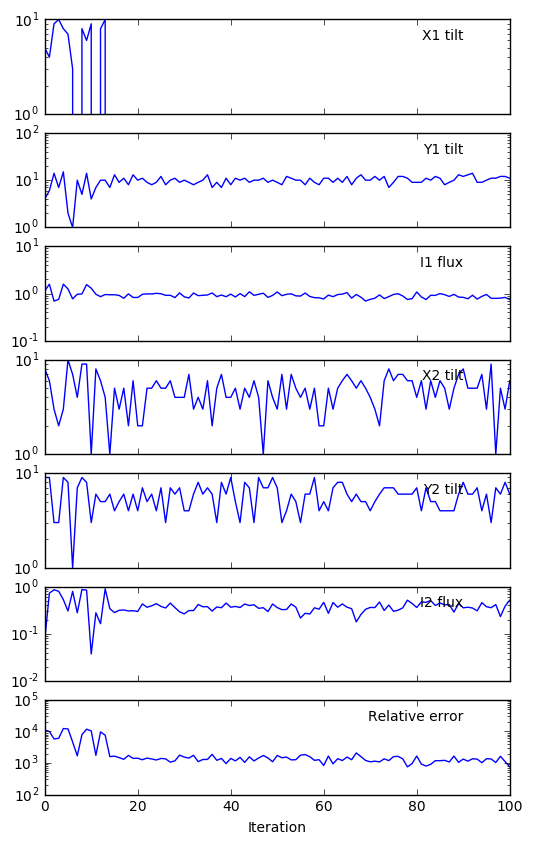

In [16]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X1,Y1,F1,X2,Y2,F2,E) = zip(*[(i,dx1-0.,dy1-5.,df1 - 1./3.,dx2-0.,dy2-0.,df2 - 1.,e/min_err) for i,((dx1,dy1,df1,dx2,dy2,df2),e,t) in enumerate(errors)])

f, axes = plt.subplots(7, sharex=True,figsize=(6,10))
labels = ['X1 tilt','Y1 tilt','I1 flux','X2 tilt','Y2 tilt','I2 flux','Relative error']
for i,V in enumerate([X1,Y1,F1,X2,Y2,F2,E]):
    axes[i].plot(I, np.abs(V))
    axes[i].text(.9,.9,labels[i],
            horizontalalignment='right', verticalalignment='top',
            transform=axes[i].transAxes)
    axes[i].locator_params(axis='y', nbins=6)
    axes[i].set_yscale('log')
axes[6].set_xlabel('Iteration')
plt.show()